# Imports

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import fbprophet
import datetime

## Web Scraping Historical Precious Metal Prices

In [3]:
## Silver 
res = requests.get("https://www.macrotrends.net/1470/historical-silver-prices-100-year-chart")
soup = BeautifulSoup(res.content, 'lxml')
tables = soup.find_all('table')
headers = ['Year', 'Average Closing', 'Year Open', 'Year High', 'Year Low', 'Year Close', 'Annual % Change']
df_silver = pd.DataFrame(pd.read_html(str(tables[0]))[0])
df_silver.columns = headers

## Gold
res = requests.get("https://www.macrotrends.net/1333/historical-gold-prices-100-year-chart")
soup = BeautifulSoup(res.content, 'lxml')
tables = soup.find_all('table')
headers = ['Year', 'Average Closing', 'Year Open', 'Year High', 'Year Low', 'Year Close', 'Annual % Change']
df_gold = pd.DataFrame(pd.read_html(str(tables[0]))[0])
df_gold.columns = headers

## Utility Functions

In [5]:
def convert_to_float_if_applicable(cell):
    if isinstance(cell, str) and '$' in cell:
        try:
            cell = float(cell.replace('$', '').replace(',',''))
            return cell
        except:
            return cell
    elif isinstance(cell, str) and '%' in cell:
        try:
            cell = float(cell.replace('%', ''))
            return cell
        except:
            return cell
    else:
        return cell

In [6]:
df_silver = df_silver.applymap(lambda cell: convert_to_float_if_applicable(cell))
df_gold = df_gold.applymap(lambda cell: convert_to_float_if_applicable(cell))
df_gold.rename(columns={'Average Closing': 'Average Closing, Gold'}, inplace=True)
df_silver.rename(columns={'Average Closing': 'Average Closing, Silver'}, inplace=True)
precious_metals_avg_cls = pd.merge(df_silver, df_gold, how='inner', on = 'Year')
precious_metals_avg_cls.set_index('Year', inplace=True)

In [7]:
precious_metals_avg_cls[['Average Closing, Silver']]\
.iplot(kind='line', xTitle='Year', color='#C0C0C0',
                  yTitle='Average Closing Price in Dollars ($)', 
       title='Average Closing Prices for Silver', width=4)

In [8]:
precious_metals_avg_cls.loc['2018':'2009'][['Average Closing, Silver']]\
.iplot(kind='line', xTitle='Year', color='black',
                  yTitle='Average Closing Price in Dollars ($)', 
       title='Average Closing Prices for Silver', width=4)

In [9]:
precious_metals_avg_cls[['Average Closing, Silver', 'Average Closing, Gold']]\
.iplot(kind='line', xTitle='Year', colors=['#C0C0C0','#ffd700'],
                  yTitle='Average Closing Price in Dollars ($)', 
       title='Average Closing Prices for Silver', width=4)

In [10]:
ratio_gold_to_silver = precious_metals_avg_cls
ratio_gold_to_silver['Ratio of Gold to Silver'] = precious_metals_avg_cls['Average Closing, Gold'] \
/ precious_metals_avg_cls['Average Closing, Silver']

precious_metals_avg_cls[['Ratio of Gold to Silver']]\
.iplot(kind='line', xTitle='Year', color='#1C7C54',
                  yTitle='Ratio of Gold Closing Price, to Silver Closing Price', 
       title='Ratio of Gold Price to Silver Price', width=4)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


## Supply

In [11]:
supply = pd.read_excel('../data/silver_institute_supply_and_demand.xlsx', 'Supply')
supply.set_index('Year', inplace=True)
supply.fillna(0, inplace=True)

In [12]:
supply.head()

,Mine Production,Net Government Sales,Scrap,Net Hedging Supply,Total Supply
Year,,,,,
2009,717.3,15.6,200.6,-17.4,916.1
2010,753.0,44.2,227.2,50.4,1074.8
2011,758.3,12.0,261.2,12.2,1043.7
2012,791.7,7.4,253.8,-47.1,1005.8
2013,823.3,7.9,191.2,-34.8,987.6


In [13]:
supply[['Total Supply']]\
.iplot(kind='bar', xTitle='Year', color='#1C7C54',
                  yTitle='Supply in Tons', 
       title='Total Supply of Silver, Per Year', width=4)

In [14]:
supply[['Mine Production','Net Government Sales','Scrap', 'Net Hedging Supply']]\
.iplot(kind='bar', xTitle='Year', 
                  yTitle='Supply in Tons', 
       title='Total Supply of Silver, Per Year', width=4)

In [15]:
supply[['Mine Production','Net Government Sales','Scrap', 'Net Hedging Supply']]\
.iplot(kind='line', xTitle='Year', 
                  yTitle='Supply in Tons', 
       title='Total Supply of Silver, Per Year', width=4)

## Demand

In [16]:
demand = pd.read_excel('../data/silver_institute_supply_and_demand.xlsx', 'Demand')
demand.set_index('Year', inplace=True)
demand.fillna(0, inplace=True)

In [17]:
demand.head()

,Jewelry,Coins & Bars,Silverware,Industrial Fabrication,…of which Electrical & Electronics,…of which Brazing Alloys & Solders,…of which Photography,…of which Photovoltaic*,…of which Ethylene Oxide,…of which Other Industrial*,Total Physical Demand
Year,,,,,,,,,,,
2009,176.9,79.6,53.2,528.2,227.4,53.8,76.4,0.0,4.8,165.8,837.9
2010,190.0,174.1,51.9,633.8,301.2,61.2,67.5,0.0,8.7,195.2,1049.8
2011,191.5,211.7,47.5,653.0,290.8,63.2,61.2,67.4,6.2,164.2,1103.7
2012,186.7,161.2,43.8,600.1,266.7,61.1,54.2,64.4,4.7,148.9,991.8
2013,219.7,240.7,59.3,604.6,266.0,63.7,50.5,54.8,7.7,162.0,1124.3


In [18]:
demand[['Total Physical Demand']]\
.iplot(kind='bar', xTitle='Year',  color='#139A43',
                  yTitle='Demand (million ounces)', 
       title='Total Demand for Silver, Per Year', width=4)

In [19]:
supply[['Mine Production','Net Government Sales','Scrap', 'Net Hedging Supply']]\
.iplot(kind='line', xTitle='Year', 
                  yTitle='Supply in Tons', 
       title='Total Supply of Silver, Per Year', width=4)

In [20]:
demand.loc[:,'Jewelry':'Industrial Fabrication'].iplot(kind='bar', xTitle='Year', 
                  yTitle='Demand in Tons', 
       title='Total Demand for Silver, Per Year and By Sector', width=4)


In [21]:
demand.loc[:,'Jewelry':'Industrial Fabrication'].iplot(kind='line', xTitle='Year', 
                  yTitle='Supply in Tons', 
       title='Total Demand for Silver, Per Year and By Sector', width=4)


### Industrial Demand Breakdown

In [22]:
demand.loc[:,'…of which Electrical & Electronics':'…of which Other Industrial*']\



,…of which Electrical & Electronics,…of which Brazing Alloys & Solders,…of which Photography,…of which Photovoltaic*,…of which Ethylene Oxide,…of which Other Industrial*
Year,,,,,,
2009,227.4,53.8,76.4,0.0,4.8,165.8
2010,301.2,61.2,67.5,0.0,8.7,195.2
2011,290.8,63.2,61.2,67.4,6.2,164.2
2012,266.7,61.1,54.2,64.4,4.7,148.9
2013,266.0,63.7,50.5,54.8,7.7,162.0
2014,263.9,66.7,48.5,53.9,5.0,158.5
2015,246.0,61.5,46.1,64.5,10.2,154.4
2016,233.9,55.3,44.7,74.9,10.2,147.3
2017,243.1,57.5,40.9,88.9,6.9,148.4


In [23]:
demand.loc[:,'…of which Electrical & Electronics':'…of which Other Industrial*']\
.iplot(kind='line', xTitle='Year', 
                  yTitle='Supply in Tons', 
       title='Total Industrial Demand for Silver, Per Year and By Industry', width=4)

### Total Demand

In [24]:
demand.loc[:,'Total Physical Demand']\
.iplot(kind='line', xTitle='Year', 
                  yTitle='Total Physical Demand', 
       title='Total Demand for Silver', width=4)

### Demand in the Electrical & Electronics Industry

In [25]:
elec_demand = demand.loc[:,'Total Physical Demand']
prophet_elec = pd.DataFrame(columns=['ds','y'])
prophet_elec['ds'] = elec_demand.index
prophet_elec['y'] = elec_demand.values

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
/Users/pst-home/anaconda3/envs/data_science/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



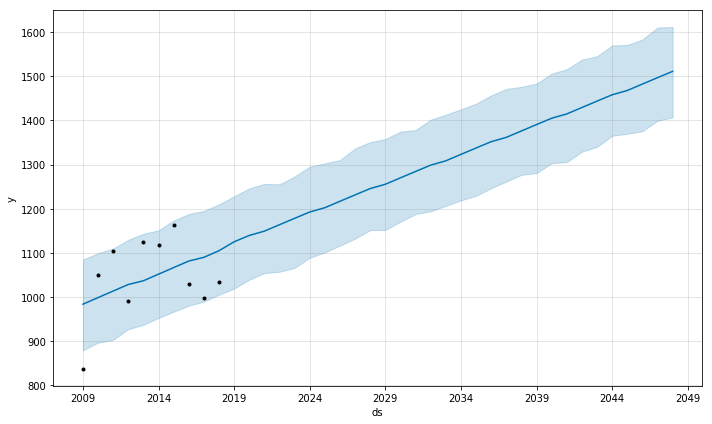

In [26]:
prophet_elec['ds']  = prophet_elec['ds'].apply(lambda d: datetime.datetime.strptime(str(d), "%Y")) 
model_elec_demand = fbprophet.Prophet()
model_elec_demand.fit(prophet_elec)
future_df_elec = model_elec_demand.make_future_dataframe(periods=30, freq='y')
forecast_elc = model_elec_demand.predict(future_df_elec)
model_elec_demand.plot(forecast_elc);

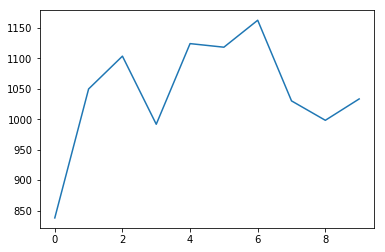

In [27]:
prophet_elec['y'].plot()

## Relative to market

## Energy Market

In [28]:
df = pd.read_excel('../Data/Enerdata_Energy_Statistical_Yearbook_2019.xlsx', 
              'Share of renewables in electri',
             skiprows=2,
             ).T
df.columns = df.iloc[0,:]
df.drop('Unnamed: 0', inplace=True)
df.drop(df.tail(2).index,inplace=True) # drop last n rows

df

Unnamed: 0,World,OECD,G7,BRICS,Europe,European Union,Belgium,Czech Republic,France,Germany,...,Egypt,Nigeria,South Africa,Middle-East,Iran,Kuwait,Saudi Arabia,United Arab Emirates,n.a. : non avalaible,Source :
1990,19.7619,17.742,15.1469,24.2174,18.0819,12.6293,1.67224,2.31621,14.1012,3.90135,...,23.5044,32.5856,1.70488,4.87801,10.2924,0,0,0,NaN,NaN
1991,19.6915,17.4916,15.1333,23.9565,18.2106,12.9545,1.7877,2.17916,13.9713,3.85206,...,22.3496,41.8649,2.24815,4.55602,11.0033,0,0,0,NaN,NaN
1992,19.6144,17.402,14.7462,24.1005,19.133,13.6388,1.98269,2.76255,16.1156,4.37848,...,21.2356,40.8454,1.24041,4.87081,13.8768,0,0,0,NaN,NaN
1993,20.2447,17.9739,15.1783,24.7198,19.704,13.9012,1.79716,2.98399,14.7922,4.61906,...,21.937,38.4143,0.853434,4.46024,12.8904,0,0,0,NaN,NaN
1994,19.9823,16.9702,14.5114,25.6983,19.6448,14.1478,1.99227,3.5721,17.4539,5.17575,...,22.2517,35.8122,1.42606,3.46033,9.0928,0,0,0,NaN,NaN
1995,20.3154,17.6101,15.1084,25.5845,19.6554,13.944,2.09655,4.40285,15.8873,5.65846,...,21.9481,34.685,0.965953,3.21867,8.57603,0,0,0,NaN,NaN
1996,19.9885,17.5794,15.5325,24.0963,18.7437,13.5605,2.00003,4.1941,14.1631,5.62362,...,20.9557,33.8607,1.78419,3.10273,8.13497,0,0,0,NaN,NaN
1997,19.8665,17.3928,15.1832,24.4313,19.1674,13.8963,1.97887,3.98464,13.9166,4.82364,...,20.5158,34.7025,2.30365,2.83599,7.0874,0,0,0,NaN,NaN
1998,19.53,16.6477,14.1628,25.045,19.6266,14.3528,2.24445,3.795,13.452,5.19777,...,19.4105,38.2172,2.06745,2.64955,6.8043,0,0,0,NaN,NaN
1999,19.1457,16.3819,14.1111,23.8646,19.7594,14.396,2.3641,4.47182,15.21,5.83714,...,21.4366,38.2124,1.73044,1.95857,4.44091,0,0,0,NaN,NaN


In [29]:
cufflinks.set_config_file(theme='white')
df.loc[:,'World'].iplot(kind='bar', xTitle='Year', 
                  yTitle='Share of Global Energy that is Renewable (%)', theme='space', 
       title='Share of Global Energy that is Renewable, Per Year', width=4)


In [30]:
df.loc[:,'World'].iplot(kind='lines', xTitle='Year', theme='ggplot',
                  yTitle='Share of Global Energy that is Renewable (%)', 
       title='Share of Global Energy that is Renewable, Per Year', width=4)


In [31]:
df_solar_wind = pd.read_excel('../Data/Enerdata_Energy_Statistical_Yearbook_2019.xlsx', 
              'Share of wind and solar in ele',
             skiprows=2,
             ).T
df_solar_wind.columns = df_solar_wind.iloc[0,:]
df_solar_wind.drop('Unnamed: 0', inplace=True)
df_solar_wind.drop(df.tail(2).index,inplace=True) # drop last n rows
df_solar_wind.head()

Unnamed: 0,World,OECD,G7,BRICS,Europe,European Union,Belgium,Czech Republic,France,Germany,...,Egypt,Nigeria,South Africa,Middle-East,Iran,Kuwait,Saudi Arabia,United Arab Emirates,n.a. : non avalaible,Source :
1990,0.517469,0.696523,0.740087,0.005364,0.177209,0.180835,0.00987,0,0.119548,0.013091,...,0,0,0,0.000409,0,0,0,0,NaN,NaN
1991,0.522381,0.702338,0.742248,0.005795,0.181986,0.187001,0.011121,0,0.113488,0.040027,...,0,0,0,0.000406,0,0,0,0,NaN,NaN
1992,0.538442,0.721369,0.758461,0.009882,0.219669,0.231734,0.012461,0,0.111293,0.054887,...,0,0,0,0.000357,0,0,0,0,NaN,NaN
1993,0.54424,0.734042,0.771127,0.010455,0.25641,0.270906,0.011294,0,0.104928,0.12864,...,0,0,0,0.000324,0,0,0,0,NaN,NaN
1994,0.560327,0.739633,0.786712,0.014905,0.282463,0.299933,0.012469,0,0.106319,0.271185,...,0,0,0,0.000303,0,0,0,0,NaN,NaN


In [32]:
df2 = pd.DataFrame(columns=['Total Global Share Renewables', 'Total Global Share Solar & Wind'])
df2['Total Global Share Renewables'] = df['World']
df2['Total Global Share Solar & Wind'] = df_solar_wind['World']

In [33]:
df2['Total Renewables minus Solar & Wind'] = df2['Total Global Share Renewables'] - df2['Total Global Share Solar & Wind']

In [72]:
myplot = df2.loc[:,['Total Global Share Solar & Wind', 'Total Renewables minus Solar & Wind']]\
.iplot(kind='bar', xTitle='Year', barmode='stack', colors = ['yellow', '#139A43'],
                  yTitle='Share of Global Energy that is Renewable (%)', theme='space', 
       title='Share of Global Energy that is Renewable, Per Year', width=4)
myplot.layout.legend=dict(x=-.1, y=2)

AttributeError: 'NoneType' object has no attribute 'layout'

In [67]:
df2.loc[:,['Total Global Share Renewables']]\
.iplot(kind='bar', xTitle='Year', barmode='stack', colors = ['yellow', '#139A43'],
                  yTitle='Share of Global Energy that is Renewable (%)', theme='space', 
       title='Share of Global Energy that is Renewable, Per Year', width=4)

In [68]:
df2

,Total Global Share Renewables,Total Global Share Solar & Wind,Total Renewables minus Solar & Wind
1990,19.7619,0.517469,19.2445
1991,19.6915,0.522381,19.1692
1992,19.6144,0.538442,19.076
1993,20.2447,0.54424,19.7004
1994,19.9823,0.560327,19.422
1995,20.3154,0.550555,19.7649
1996,19.9885,0.565139,19.4234
1997,19.8665,0.573321,19.2932
1998,19.53,0.583953,18.946
1999,19.1457,0.630428,18.5153


In [35]:
df2.loc[:,['Total Global Share Solar & Wind', 'Total Renewables minus Solar & Wind']]\
.iplot(kind='line', xTitle='Year', legend='top',
                  yTitle='Share of Global Energy that is Renewable (%)', theme='space', 
       title='Share of Global Energy that is Renewable, Per Year', width=4)


### Solar/Wind Share Forecast 

In [36]:
df3 = pd.DataFrame(columns=['ds','y'])
df3['ds'] = df2.index
df3['y'] = df2['Total Global Share Solar & Wind'].values

In [37]:
df3['ds']  = df3['ds'].apply(lambda d: datetime.datetime.strptime(str(d), "%Y")) 
df3.dropna(inplace=True)

In [38]:
m_ws = fbprophet.Prophet(changepoint_prior_scale=0.15)
m_ws.fit(df3)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.0.


In [39]:
future_ws = m_ws.make_future_dataframe(periods=30, freq='y')
forecast_ws = m_ws.predict(future_ws)

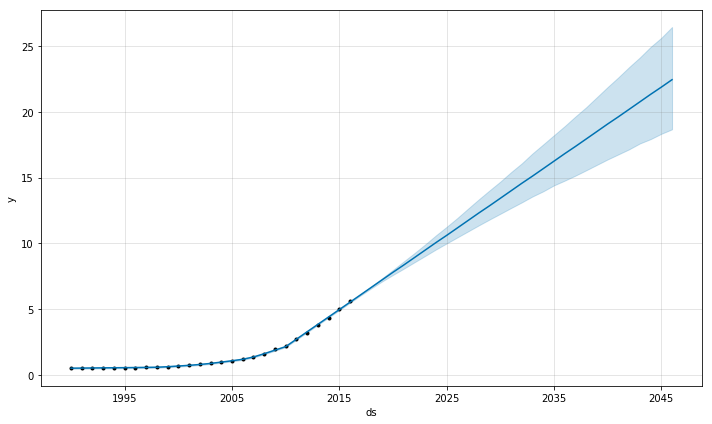

In [40]:
m_ws.plot(forecast_ws);

In [41]:
perc_inc_df = pd.DataFrame(columns=['ds', 'y', 'yhat', 'perc_on_prev'])
perc_inc_df['ds'] = forecast_ws['ds']
perc_inc_df['y'] = df3['y']
perc_inc_df['yhat'] = forecast_ws['yhat']
# forecast_ws.loc[:,['ds', 'yhat']]
# perc_inc_df

In [42]:
perc_inc_df['perc_on_prev'] = perc_inc_df['yhat'].pct_change()

In [43]:
final_perc_inc_df = perc_inc_df.iloc[30:, :][['ds', 'perc_on_prev']]
        

In [44]:
final_perc_inc_df

,ds,perc_on_prev
30,2019-12-31,0.078670
31,2020-12-31,0.070431
32,2021-12-31,0.067818
33,2022-12-31,0.063659
34,2023-12-31,0.059988
35,2024-12-31,0.054652
36,2025-12-31,0.053411
37,2026-12-31,0.050822
38,2027-12-31,0.048476
39,2028-12-31,0.044649


In [45]:
modern_ene_cons = pd.read_csv('../data/modern-renewable-energy-consumption.csv')

In [46]:
solar_con = modern_ene_cons[modern_ene_cons['Entity']=='World'][['Year', 'Solar (terawatt-hours)']]

In [65]:
solar_con.set_index('Year').loc[:,:]\
.iplot(kind='line', xTitle='Year',color='#139A43',
                  yTitle='Consumption (TWh)', theme='space', 
       title='Total World Solar Energy Consumption', width=4)

In [79]:
solar_con_for_prophet = solar_con.copy().iloc[20:]

In [80]:
solar_con_for_prophet.rename(columns={'Year':'ds',
                          'Solar (terawatt-hours)':'y'}, inplace=True)

In [81]:
solar_con_for_prophet['ds'] = solar_con_for_prophet['ds'].apply(lambda d: datetime.datetime.strptime(str(d), "%Y")) 

In [82]:
m_solar = fbprophet.Prophet(changepoint_prior_scale=80, 
                            growth='linear'
                           )

In [83]:
m_solar.fit(solar_con_for_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 24.0.
/Users/pst-home/anaconda3/envs/data_science/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [84]:
future_solar = m_solar.make_future_dataframe(periods=30, freq='y')

In [85]:
forecast_solar = m_solar.predict(future_solar)

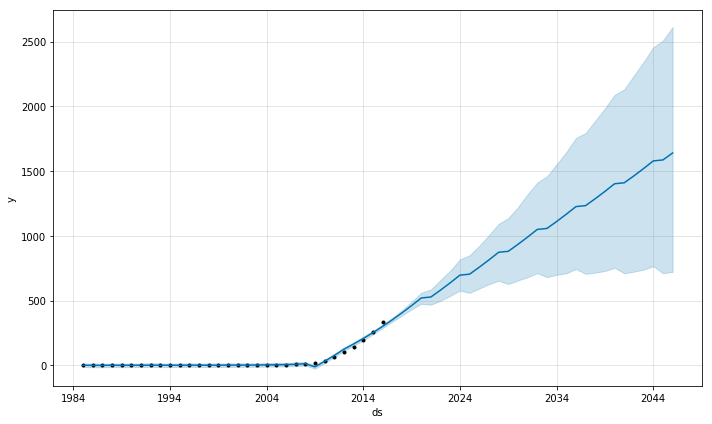

In [86]:
m_solar.plot(forecast_solar);

In [74]:
# Total Solar Demand minus Thrifting 

In [90]:
solar_dem_min_thrift = solar_con.copy().iloc[44:]
solar_dem_min_thrift

,Year,Solar (terawatt-hours)
4168,2009,20.917919
4169,2010,33.816254
4170,2011,64.695112
4171,2012,100.033907
4172,2013,137.561154
4173,2014,196.332988
4174,2015,256.190929
4175,2016,333.052493


### Top 5 Producers - Company Stock Analysis

In [56]:
# Market Caps

In [57]:
fres_mex = pd.read_excel('../data/company_data/market_cap/fresnillo/MEX_FRES market-cap Data 2019-10-30 16_21_41.xlsx',
                        skiprows=4)
kghm = pd.read_excel('../data/company_data/market_cap/kghm_polska/WAR_KGH market-cap Data 2019-10-31 04_41_48.xlsx',
                        skiprows=4)
glencore = pd.read_excel('../data/company_data/market_cap/glencore_switz/GLCNF market-cap Data 2019-10-31 04_47_44.xlsx',
                        skiprows=4)
goldcorp = pd.read_excel('../data/company_data/market_cap/goldcorp_canada/TSX_G market-cap Data 2019-10-31 04_49_53.xlsx',
                        skiprows=4)
polymetal = pd.read_excel('../data/company_data/market_cap/polymetal_canada/PLM market-cap Data 2019-10-31 04_52_20.xlsx',
                        skiprows=4)
panam = pd.read_excel('../data/company_data/market_cap/pan_american_silver_canada/PAAS market-cap Data 2019-10-31 04_54_16.xlsx',
                        skiprows=4)
jianxi = pd.read_excel('../data/company_data/market_cap/Jiangxi/SHSE_600362 market-cap Data 2019-10-31 04_58_58.xlsx',
                        skiprows=4)


FileNotFoundError: [Errno 2] No such file or directory: '../data/company_data/market_cap/goldcorp_canada/TSX_G market-cap Data 2019-10-31 04_49_53.xlsx'

In [ ]:
test = cufflinks.datagen.lines(4, mode='abc')

In [ ]:
test.head()

In [ ]:
fres_uk['Date'] = pd.to_datetime(fres_uk['Date'])
fres_mex['Date'] = pd.to_datetime(fres_mex['Date'])

In [ ]:
fres_uk.iplot(kind='line', xTitle='Year', x='Date', y='Data',
                  yTitle='Share of Global Energy that is Renewable (%)', theme='space', 
       title='Share of Global Energy that is Renewable, Per Year', width=4)


In [ ]:
fres_mex.iplot(kind='line', xTitle='Year', x='Date', y='Data',
                  yTitle='Share of Global Energy that is Renewable (%)', theme='space', 
       title='Share of Global Energy that is Renewable, Per Year', width=4)
